# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

"""
Gesture Recognition Project
==========================
This notebook provides a streamlined approach to developing gesture recognition models
using three different architectures and optional transfer learning components.

Supported model architectures:
- Conv3D
- Conv2D + LSTM
- Conv2D + GRU

Dataset path: /home/datasets/Project_data
"""

In [18]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize # For image resize; as per assignment images of different sizes will need be resized to similiar size before trainig
import datetime
import random
import matplotlib.pyplot as plt # For Visualisation
from PIL import Image, ImageFilter, ImageEnhance # For Data Augmentation

We set the random seed so that the results don't vary drastically.

In [19]:
# Set random seeds for reproducibility
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)

In [20]:
# Import TensorFlow components
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, TimeDistributed,
    Dense, Dropout, Flatten, BatchNormalization, 
    GlobalAveragePooling2D, GlobalAveragePooling3D,
    LSTM, GRU, Input, Add, Concatenate, LeakyReLU, Bidirectional
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping # Callbacks

from tensorflow.keras.optimizers import Adam # Optimizer - Always ADAM
from tensorflow.keras.applications import MobileNetV2, ResNet50V2 # for transfer learning

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [21]:

# DATA LOADING AND PREPROCESSING


def load_data(data_path='/home/datasets/Project_data'):
    """Load training and validation data from CSV files."""
    train_doc = np.random.permutation(open(f'{data_path}/train.csv').readlines())
    val_doc = np.random.permutation(open(f'{data_path}/val.csv').readlines())
    
    print(f'# training sequences = {len(train_doc)}')
    print(f'# validation sequences = {len(val_doc)}')
    
    return train_doc, val_doc

### Analyze Class distribution

**Need to see if it affects training**



In [22]:
def analyze_class_distribution(data_list):
    """Analyze class distribution and return class weights using median frequency balancing."""
    class_counts = {0:0, 1:0, 2:0, 3:0, 4:0}
    
    for entry in data_list:
        label = int(entry.strip().split(';')[2])
        class_counts[label] += 1
    
    total = sum(class_counts.values())
    percentages = {c: (count/total*100) for c, count in class_counts.items()}
    
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"Class {cls}: {count} samples ({percentages[cls]:.1f}%)")
    
    # Using median frequency balancing
    median = np.median(list(class_counts.values()))
    class_weights = {c: median/count for c, count in class_counts.items()}
    
    print("\nClass weights using median frequency balancing:")
    for c, w in class_weights.items():
        print(f"Class {c}: {w:.2f}")
    
    return class_weights

### dynamic frame selection

In [23]:
def dynamic_frame_selection(total_frames, num_frames=10):
    """
    Dynamically select frames from a video of any length.
    
    Args:
        total_frames: Total number of frames in the video
        num_frames: Number of frames to select
        
    Returns:
        List of frame indices
    """
    if total_frames <= num_frames:
        # If we have fewer frames than needed, may need to repeat
        indices = list(range(total_frames))
        # If needed, add  sampling from existing frames
        if len(indices) < num_frames:
            extra = random.choices(indices, k=num_frames-len(indices))
            indices.extend(extra)
        return sorted(indices)
    else:
        # If we have more frames than needed, sample evenly across the video
        return sorted(np.linspace(0, total_frames - 1, num_frames).astype(int))

### Visualization with sample sequence
**Square Cropping**
**Resizing**

In [25]:
def visualize_sample_sequence(source_path, folder_str, seq_length=10, dim_x=120, dim_y=120):
    """Visualize a sample sequence of images from the dataset."""
    folder_name = folder_str.strip().split(';')[0]
    label = int(folder_str.strip().split(';')[2])
    
    folder_path = os.path.join(source_path, folder_name)
    imgs = sorted([f for f in os.listdir(folder_path) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    # Use dynamic frame selection
    selected_indices = dynamic_frame_selection(len(imgs), seq_length)
    
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(selected_indices):
        if idx < len(imgs):
            image_path = os.path.join(folder_path, imgs[idx])
            image = imread(image_path)
            
            # Display original image
            plt.subplot(2, len(selected_indices), i+1)
            plt.title(f"Original #{idx}")
            plt.imshow(image)
            plt.axis('off')
            
            # Process image with square crop
            h, w = image.shape[:2]
            crop_size = min(h, w)
            y = (h - crop_size) // 2
            x = (w - crop_size) // 2
            cropped = image[y:y+crop_size, x:x+crop_size]
            
            # Resize to target dimensions
            resized = resize(cropped, (dim_x, dim_y))
            
            # Display processed image
            plt.subplot(2, len(selected_indices), i+len(selected_indices)+1)
            plt.title(f"Processed #{idx}")
            plt.imshow(resized)
            plt.axis('off')
    
    plt.suptitle(f"Sample sequence from class {label}")
    plt.tight_layout()
    plt.show()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

**Generates batches of video sequences for training or validation**

***Dynamically selects frames for each sequence.***

***Applies preprocessing (cropping, resizing) and optional augmentations (rotation, flipping, brightness adjustment).***

***Normalizes images based on the model type:***

> ***For MobileNetV2 or ResNet50V2, scales pixel values to [−1,1][−1,1].***

> ***Otherwise, normalizes to [1][1].***

***Outputs batches in the format (batch_size,seq_length,height,width,channels)(batch_size,seq_length,height,width,channels).***


In [26]:

# DATA GENERATOR


def generator(source_path, folder_list, batch_size, seq_length=10,
              dim_x=120, dim_y=120, is_train=False, enable_augmentation=False, model_type=None,base_model=None):
    """
    Simplified generator with motion-aware augmentation and proper normalization.
    
    Args:
        source_path: Path to the source directory
        folder_list: List of folders to process
        batch_size: Number of sequences per batch
        seq_length: Number of frames to use for each sequence
        dim_x, dim_y: Target dimensions for the images
        is_train: Whether this generator is for training data
        enable_augmentation: Whether to apply data augmentation
        model_type: Type of model to normalize for ('transfer' or None)
        base_model: Base model in case of transfer learning
    """
    print(f'Source path = {source_path}; batch size = {batch_size}; augmentation = {enable_augmentation}')
    
    while True:
        # Shuffle the data for each epoch
        if is_train:
            t = np.random.permutation(folder_list)
        else:
            t = folder_list
        
        for batch_start in range(0, len(t), batch_size):
            batch_end = min(batch_start + batch_size, len(t))
            current_batch = t[batch_start:batch_end]
            current_batch_size = len(current_batch)
            
            # Initialize batch arrays
            batch_data = np.zeros((batch_size, seq_length, dim_x, dim_y, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, 5))
            
            for folder_idx in range(current_batch_size):
                folder_str = current_batch[folder_idx]
                folder_name = folder_str.strip().split(';')[0]
                label = int(folder_str.strip().split(';')[2])
                
                # Get the list of image files
                folder_path = os.path.join(source_path, folder_name)
                imgs = sorted([f for f in os.listdir(folder_path) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                
                # Dynamic frame selection
                selected_indices = dynamic_frame_selection(len(imgs), seq_length)
                
                # Generate sequence-level augmentation parameters (for temporal coherence)
                sequence_aug_params = None
                if is_train and enable_augmentation and random.random() < 0.5:
                    sequence_aug_params = {
                        # augmentation intensity
                        'angle': random.uniform(-10, 10),
                        'flip': random.random() < 0.5,
                        'brightness': random.uniform(0.8, 1.2),
                        'aug_type': random.randint(0, 4)
                    }
                
                # Process each frame in the sequence
                for frame_idx, img_pos in enumerate(selected_indices):
                    if img_pos >= len(imgs):
                        img_pos = len(imgs) - 1
                    
                    # Read the image
                    image_path = os.path.join(folder_path, imgs[img_pos])
                    image = imread(image_path)
                    
                    # Center crop to square
                    h, w = image.shape[:2]
                    crop_size = min(h, w)
                    y = (h - crop_size) // 2
                    x = (w - crop_size) // 2
                    cropped = image[y:y+crop_size, x:x+crop_size]
                    
                    # Resize to target dimensions
                    resized = resize(cropped, (dim_x, dim_y))
                    
                    # Convert to uint8 for PIL processing (0-255 range)
                    image_uint8 = (resized * 255).astype(np.uint8)
                    
                    # Apply consistent sequence-level augmentations if enabled
                    if sequence_aug_params is not None:
                        # Convert to PIL image for augmentation
                        pil_image = Image.fromarray(image_uint8)
                        
                        # Apply rotation 
                        if sequence_aug_params['angle'] != 0:
                            pil_image = pil_image.rotate(
                                sequence_aug_params['angle'], 
                                resample=Image.BILINEAR,
                                expand=False
                            )
                        
                        # Apply flip
                        if sequence_aug_params['flip']:
                            pil_image = pil_image.transpose(Image.FLIP_LEFT_RIGHT)
                        
                        # Apply filter-based augmentations
                        aug_type = sequence_aug_params['aug_type']
                        if aug_type == 0:  # Edge Enhancement
                            pil_image = pil_image.filter(ImageFilter.EDGE_ENHANCE)
                        elif aug_type == 1:  # Gaussian Blur (reduced intensity)
                            pil_image = pil_image.filter(ImageFilter.GaussianBlur(0.5))
                        elif aug_type == 2:  # Detail enhancement
                            pil_image = pil_image.filter(ImageFilter.DETAIL)
                        elif aug_type == 3:  # Sharpening
                            pil_image = pil_image.filter(ImageFilter.SHARPEN)
                        elif aug_type == 4:  # Brightness adjustment
                            enhancer = ImageEnhance.Brightness(pil_image)
                            pil_image = enhancer.enhance(sequence_aug_params['brightness'])
                        
                        # Convert back to numpy array and normalize to [0, 1]
                        resized = np.array(pil_image).astype(np.float32) / 255.0
                    else:
                        # Normalize original resized image to [0, 1]
                        resized = resized.astype(np.float32)
                    
                    

                    if model_type == 'transfer':
                        # Apply simple normalization based on the model type
                        if base_model and 'mobilenet' in base_model.lower():
                            # MobileNetV2: scales to [-1,1]
                            resized = (resized * 2.0) - 1.0
                        elif base_model and 'resnet' in base_model.lower():
                            # ResNet: simple normalization to [-1,1]
                            resized = (resized * 2.0) - 1.0
                    else:
                        # Default normalization to [-1,1]
                        resized = (resized - 0.5) * 2.0
                    
                    # Store in batch
                    batch_data[folder_idx, frame_idx] = resized
                
                # One-hot encode the label
                batch_labels[folder_idx, label] = 1
            
            # If batch is not full (last batch might be smaller), slice to actual size
            if current_batch_size < batch_size:
                batch_data = batch_data[:current_batch_size]
                batch_labels = batch_labels[:current_batch_size]
            
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

a. Conv3D Model - Residual Connection, Batchnormalization , Leaky Relu, Dropuout ends with soft max
b. CNN-GRU Model - Timeddistributed CNN with temporal model with GRU
c. CNN-LSTM Model - Similiar to (b) but with LSTM
d. Transfer Learning Model - Uses pre-trained MobileNetV2 or ResNet50V2; fine-tune top layer with unfreeze percentage

In [27]:

# MODEL ARCHITECTURES


def create_conv3d_model(input_shape, learning_rate=0.0001):
    """3D CNN model with residual connections.
    
       
    Args:
        input_shape (tuple): Shape of the input data (frames, height, width, channels).
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        model: Compiled Keras model.
    
    
    """
    
    inputs = Input(shape=input_shape)
    
    # First block
    x = Conv3D(16, kernel_size=(3, 3, 3), padding='same')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling3D(pool_size=(1, 2, 2))(x)
    
    # Second block with residual connection
    res = Conv3D(32, kernel_size=(1, 1, 1), padding='same')(x)
    x = Conv3D(32, kernel_size=(3, 3, 3), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Add()([x, res])  # Residual connection
    x = MaxPooling3D(pool_size=(2, 2, 2))(x)
    x = Dropout(0.3)(x)
    
    # Third block with residual connection
    res = Conv3D(64, kernel_size=(1, 1, 1), padding='same')(x)
    x = Conv3D(64, kernel_size=(3, 3, 3), padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Add()([x, res])  # Residual connection
    x = GlobalAveragePooling3D()(x)
    x = Dropout(0.5)(x)
    
    # Output layer
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model


def create_cnn_gru_model(input_shape, learning_rate=0.0001):
    """
       
    Args:
        input_shape (tuple): Shape of the input data (frames, height, width, channels).
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        # TimeDistributed CNN layers
        TimeDistributed(Conv2D(16, (3, 3), padding='same'), input_shape=input_shape),
        TimeDistributed(BatchNormalization(momentum=0.9)),
        TimeDistributed(LeakyReLU(alpha=0.1)),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        TimeDistributed(Conv2D(32, (3, 3), padding='same')),
        TimeDistributed(BatchNormalization(momentum=0.9)),
        TimeDistributed(LeakyReLU(alpha=0.1)),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        # Temporal GRU layers
        TimeDistributed(Flatten()),
        GRU(128, return_sequences=True),
        GRU(64),
        
        # Classification
        Dense(5, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

def create_cnn_lstm_model(input_shape, learning_rate=0.0001):
    """
       
    Args:
        input_shape (tuple): Shape of the input data (frames, height, width, channels).
        learning_rate (float): Learning rate for the optimizer.
    
    Returns:
        model: Compiled Keras model.
    """
    model = Sequential([
        # TimeDistributed CNN layers
        TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')),
        TimeDistributed(MaxPooling2D((2, 2))),
        
        # Flatten and LSTM layers
        TimeDistributed(Flatten()),
        LSTM(64, return_sequences=True),
        LSTM(64),
        
        # Output layer
        Dense(5, activation='softmax')  # Assuming 5 classes for classification
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    return model


def create_transfer_learning_model(input_shape, learning_rate=0.0001, base_model='mobilenet', unfreeze_percent=30):
    """
    Create a transfer learning model with pretrained CNN and temporal processing.
    
    Args:
        input_shape: Input shape (frames, height, width, channels)
        learning_rate: Learning rate for the optimizer
        base_model: Base model to use ('mobilenet' or 'resnet')
        unfreeze_percent: Percentage of layers to unfreeze from the top (e.g., 30 means unfreeze the last 30% of layers)
    """
    # Get number of frames and image dimensions
    frames, height, width, channels = input_shape
    
    # Choose base model
    if base_model.lower() == 'mobilenet':
        base_cnn = MobileNetV2(
            input_shape=(height, width, channels),
            include_top=False,
            weights='imagenet'
        )
    elif base_model.lower() == 'resnet':
        base_cnn = ResNet50V2(
            input_shape=(height, width, channels),
            include_top=False,
            weights='imagenet'
        )
    else:
        raise ValueError(f"Unsupported base model: {base_model}")
    
    # Calculate number of layers to unfreeze
    total_layers = len(base_cnn.layers)
    unfreeze_layers = max(1, int(total_layers * unfreeze_percent / 100))
    print(f"Total layers in {base_model}: {total_layers}")
    print(f"Unfreezing the last {unfreeze_layers} layers ({unfreeze_percent}% of total)")
    
    # Freeze most layers but unfreeze the specified percentage from the top
    for layer in base_cnn.layers[:-unfreeze_layers]:
        layer.trainable = False
    for layer in base_cnn.layers[-unfreeze_layers:]:
        layer.trainable = True
    
    # Create feature extractor
    feature_extractor = Model(
        inputs=base_cnn.input,
        outputs=GlobalAveragePooling2D()(base_cnn.output)
    )
    
    # Build full model
    sequence_input = Input(shape=input_shape)
    encoded_frames = TimeDistributed(feature_extractor)(sequence_input)
    
    # Temporal processing
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(encoded_frames)
    x = LSTM(64, return_sequences=False)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = Dropout(0.5)(x)
    
    # Classification
    outputs = Dense(5, activation='softmax')(x)
    
    model = Model(inputs=sequence_input, outputs=outputs)
    
    # Lower learning rate for transfer learning
    optimizer = Adam(learning_rate=learning_rate / 5)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy']
    )
    
    return model

### Utility fucntions for all models
**Callbacks**
**Plotting**
**Step Calculation**

In [28]:

# TRAINING UTILITIES


def create_callbacks(model_name_prefix):
    """

    ModelCheckpoint: Saves the best model based on validation accuracy.

    ReduceLROnPlateau: Reduces learning rate if validation loss plateaus.

    EarlyStopping: Stops training if validation loss does not improve for several epochs.
."""
    # Generate model name with timestamp
    timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    model_name = f"{model_name_prefix}_{timestamp}"
    
    # Create directory if it doesn't exist
    os.makedirs(model_name, exist_ok=True)
    
    # Define checkpoint filepath
    filepath = os.path.join(
        model_name, 
        "model-{epoch:03d}-{val_categorical_accuracy:.4f}.h5"
    )
    
    # Model checkpoint callback
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor='val_categorical_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Reduce learning rate callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
    
    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    return [checkpoint, reduce_lr, early_stopping]

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Main training function
**Checks class imbalance**
** Visualize sample**
** Sets up data geenrators**
** Creates models**
** Compile models**
** Calculate steps**
** Defines Callbacks**
** Trains Model**
** Plots Model**

In [29]:

# MAIN TRAINING FUNCTION


def train_gesture_model(model_type='conv3d', transfer_learning=False, base_model='resnet',
                        batch_size=32, num_epochs=50, enable_augmentation=True,
                        learning_rate=0.0001, dim_x=120, dim_y=120, seq_length=10,
                        unfreeze_percent=30):
    """
    Train a gesture recognition model with the specified configuration.
    
    Args:
        model_type: Type of model to train ('conv3d', 'cnn_lstm', 'cnn_gru', or 'transfer')
        transfer_learning: Whether to use transfer learning
        base_model: Base model for transfer learning ('mobilenet' or 'resnet')
        batch_size: Batch size for training
        num_epochs: Number of epochs to train
        enable_augmentation: Whether to use data augmentation
        learning_rate: Learning rate for the optimizer
        dim_x, dim_y: Target dimensions for the images
        seq_length: Number of frames to use for each sequence
        unfreeze_percent: Percentage of layers to unfreeze from the top (for transfer learning)
    """
    # Load and validate datasets
    data_path = '/home/datasets/Project_data'
    train_path = f'{data_path}/train'
    val_path = f'{data_path}/val'
    
    train_doc, val_doc = load_data(data_path)
    
    # Analyze class distribution and get class weights
    class_weights = analyze_class_distribution(train_doc)
    
    # Visualize a sample sequence
    visualize_sample_sequence(train_path, train_doc[0], seq_length, dim_x, dim_y)
    
    # Determine generator normalization based on model type
    generator_model_type = 'transfer' if transfer_learning or model_type == 'transfer' else None
    
    # Set up data generators
    train_generator = generator(
        train_path, train_doc, batch_size, seq_length,
        dim_x, dim_y, is_train=True, enable_augmentation=enable_augmentation,
        model_type=generator_model_type,base_model=base_model
    )
    
    # No augmentation for validation
    val_generator = generator(
        val_path, val_doc, batch_size, seq_length,
        dim_x, dim_y, is_train=False, enable_augmentation=False,
        model_type=generator_model_type,base_model=base_model
    )
    
    # Calculate steps per epoch
    steps_per_epoch = (len(train_doc) + batch_size - 1) // batch_size
    validation_steps = (len(val_doc) + batch_size - 1) // batch_size
    
    print(f'Steps per epoch: {steps_per_epoch}')
    print(f'Validation steps: {validation_steps}')
    
    # Define input shape - (frames, height, width, channels)
    input_shape = (seq_length, dim_x, dim_y, 3)
    
    # Create model
    if transfer_learning or model_type == 'transfer':
        model = create_transfer_learning_model(
            input_shape, learning_rate, base_model, unfreeze_percent
        )
        model_name_prefix = f'gesture_transfer_{base_model}'
    elif model_type == 'conv3d':
        model = create_conv3d_model(input_shape, learning_rate)
        model_name_prefix = 'gesture_conv3d'
    elif model_type == 'cnn_lstm':
        model = create_cnn_lstm_model(input_shape, learning_rate)
        model_name_prefix = 'gesture_cnn_lstm'
    elif model_type == 'cnn_gru':
        model = create_cnn_gru_model(input_shape, learning_rate)
        model_name_prefix = 'gesture_cnn_gru'
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Display model summary
    model.summary()
    
    # Create callbacks
    callbacks = create_callbacks(model_name_prefix)
    
    # Train model with class weights
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=validation_steps,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )
    
    # Save final model
    model.save(f"{model_name_prefix}_final.h5")
    
    return model, history, model_name_prefix

def plot_training_validation_accuracy(results):
    plt.figure(figsize=(12, 8))
    
    # Define different line styles and colors for better visualization
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    styles = ['-', '--', '-.', ':']
    
    for i, (model_name, result) in enumerate(results.items()):
        history = result['history']  # This is correct - we access the history object
        epochs = range(1, len(history.history['categorical_accuracy']) + 1)
        
        color = colors[i % len(colors)]
        
        # Plot training accuracy
        plt.plot(epochs, history.history['categorical_accuracy'], 
                 color=color, linestyle=styles[0],
                 label=f'{model_name} - Training')
        
        # Plot validation accuracy
        plt.plot(epochs, history.history['val_categorical_accuracy'], 
                 color=color, linestyle=styles[1], 
                 label=f'{model_name} - Validation')
    
    # Graph details
    plt.title('Training and Validation Accuracy for Each Model')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Save the plot
    plt.savefig('model_comparison_accuracy.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()

# Bringing it all together
**Training all models sequentially, save, and compare

Gesture Recognition Training
- Frames per sequence: 10
- Image dimensions: 120x120
- Learning rate: 0.0001
- Batch size (standard models): 32
- Batch size (transfer learning): 16
- Max epochs: 50

--------------------------------------------------
Training 3D CNN model
--------------------------------------------------
# training sequences = 663
# validation sequences = 100
Class distribution:
Class 0: 136 samples (20.5%)
Class 1: 137 samples (20.7%)
Class 2: 130 samples (19.6%)
Class 3: 137 samples (20.7%)
Class 4: 123 samples (18.6%)

Class weights using median frequency balancing:
Class 0: 1.00
Class 1: 0.99
Class 2: 1.05
Class 3: 0.99
Class 4: 1.11


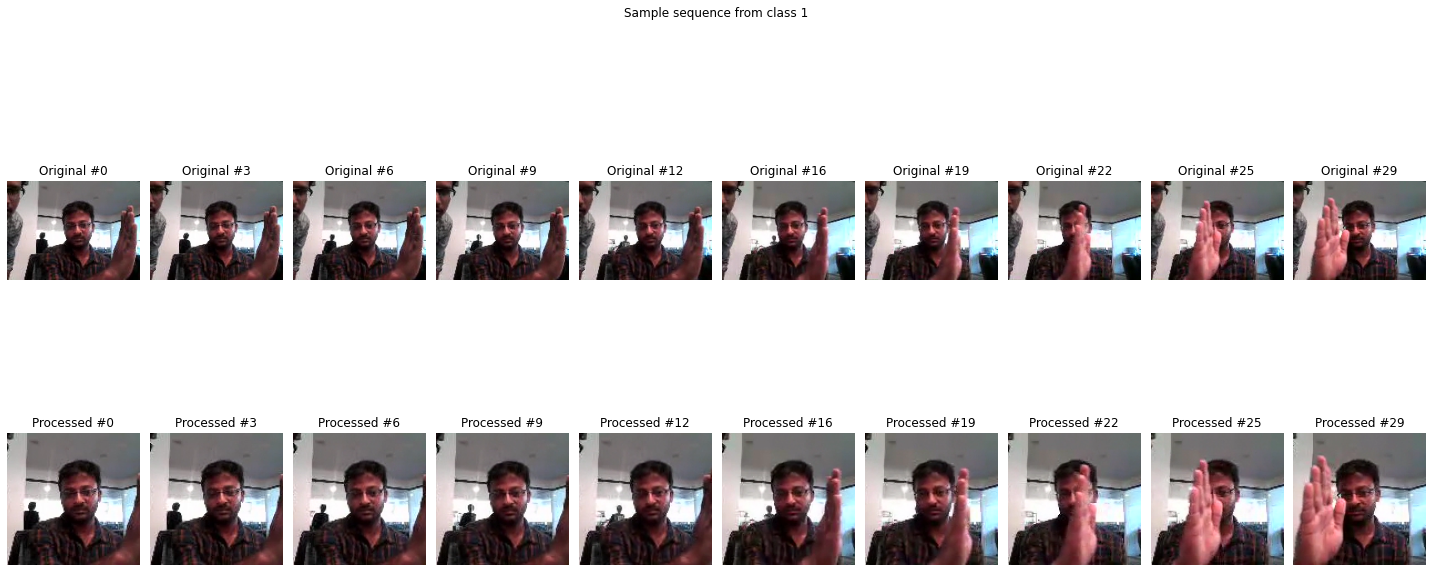

Steps per epoch: 21
Validation steps: 4


2025-04-02 14:26:44.002559: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 14:26:44.048992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 14:26:44.052047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 14:26:44.058127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-02 14:26:44.061191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 120, 12  0           []                               
                                0, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 10, 120, 120  1312        ['input_1[0][0]']                
                                , 16)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 120, 120  64         ['conv3d[0][0]']                 
 alization)                     , 16)                                                         

2025-04-02 14:26:47.842229: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302
2025-04-02 14:26:49.585168: I tensorflow/stream_executor/cuda/cuda_blas.cc:1792] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


21/21 [==============================] - ETA: 0s - loss: 2.0660 - categorical_accuracy: 0.2504Source path = /home/datasets/Project_data/val; batch size = 32; augmentation = False

Epoch 00001: val_categorical_accuracy improved from -inf to 0.22000, saving model to gesture_conv3d_20250402_142644/model-001-0.2200.h5
21/21 [==============================] - 40s 2s/step - loss: 2.0660 - categorical_accuracy: 0.2504 - val_loss: 1.6486 - val_categorical_accuracy: 0.2200 - lr: 1.0000e-04
Epoch 2/50
 1/21 [>.............................] - ETA: 1s - loss: 1.7329 - categorical_accuracy: 0.2500

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


21/21 [==============================] - ETA: 0s - loss: 1.9437 - categorical_accuracy: 0.2443
Epoch 00002: val_categorical_accuracy improved from 0.22000 to 0.47000, saving model to gesture_conv3d_20250402_142644/model-002-0.4700.h5
21/21 [==============================] - 33s 2s/step - loss: 1.9437 - categorical_accuracy: 0.2443 - val_loss: 1.3717 - val_categorical_accuracy: 0.4700 - lr: 1.0000e-04
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.7419 - categorical_accuracy: 0.2805
Epoch 00003: val_categorical_accuracy improved from 0.47000 to 0.49000, saving model to gesture_conv3d_20250402_142644/model-003-0.4900.h5
21/21 [==============================] - 32s 2s/step - loss: 1.7419 - categorical_accuracy: 0.2805 - val_loss: 1.3043 - val_categorical_accuracy: 0.4900 - lr: 1.0000e-04
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 1.6986 - categorical_accuracy: 0.2805
Epoch 00004: val_categorical_accuracy did not improve from 0.49000
21/21 [=

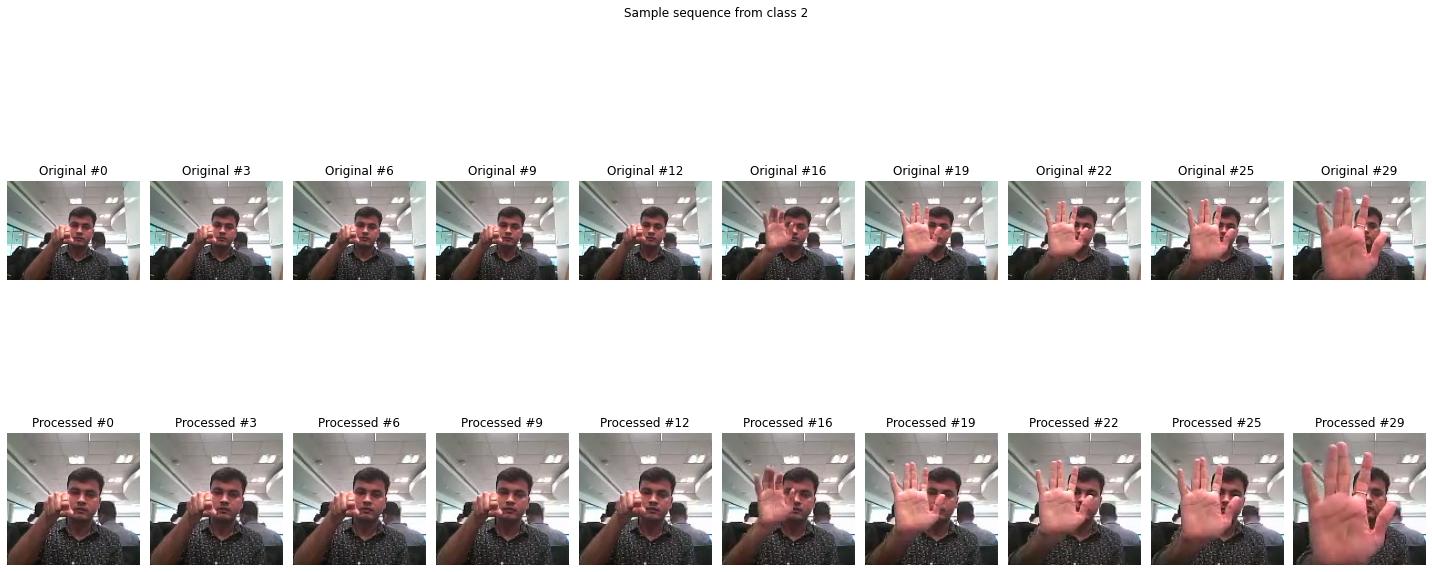

Steps per epoch: 21
Validation steps: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 30, 30, 32)   0         
 tributed)                                                       
                                                                 
 time_distribute

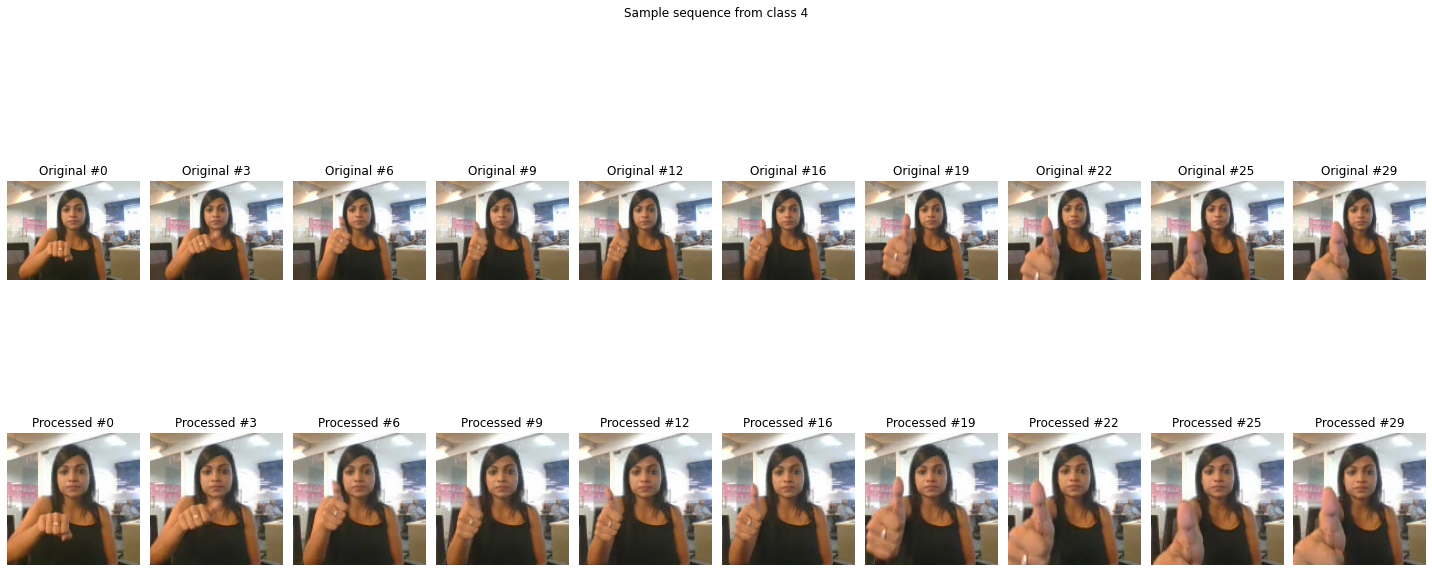

Steps per epoch: 21
Validation steps: 4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 120, 120, 16)  0        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distribute

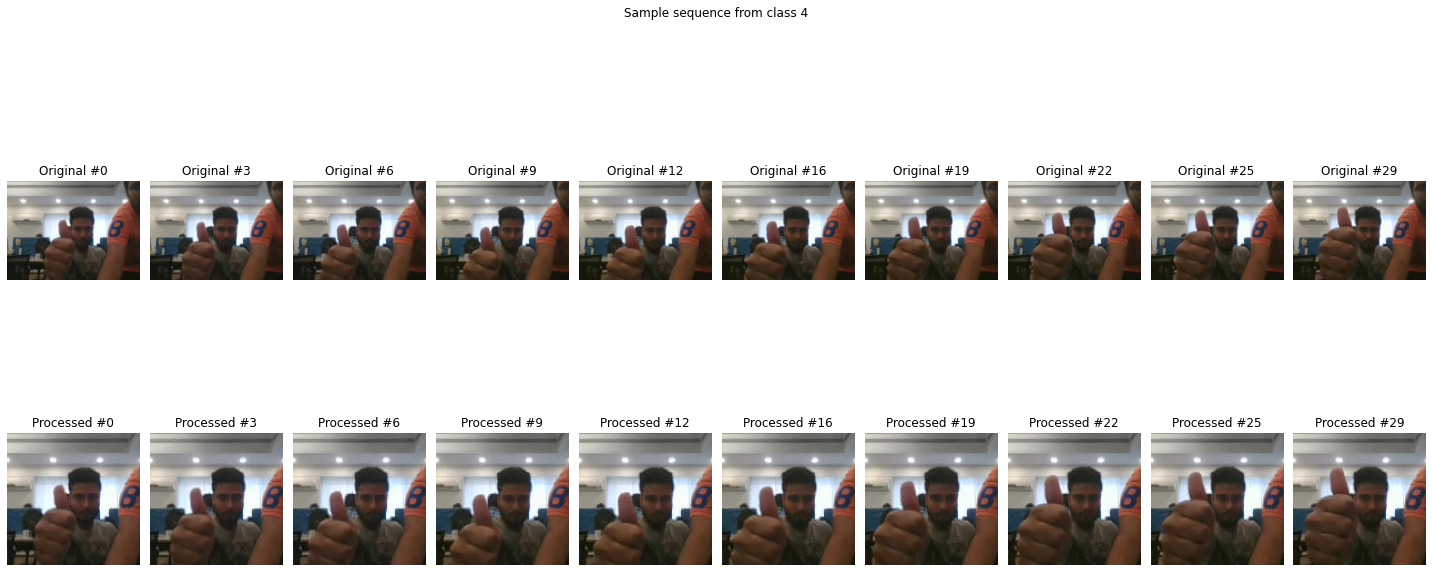

Steps per epoch: 42
Validation steps: 7
9420800/9406464 [==============================] - 0s 0us/step
Total layers in mobilenet: 154
Unfreezing the last 46 layers (30% of total)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 1280)         2257984   
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          688640    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
            

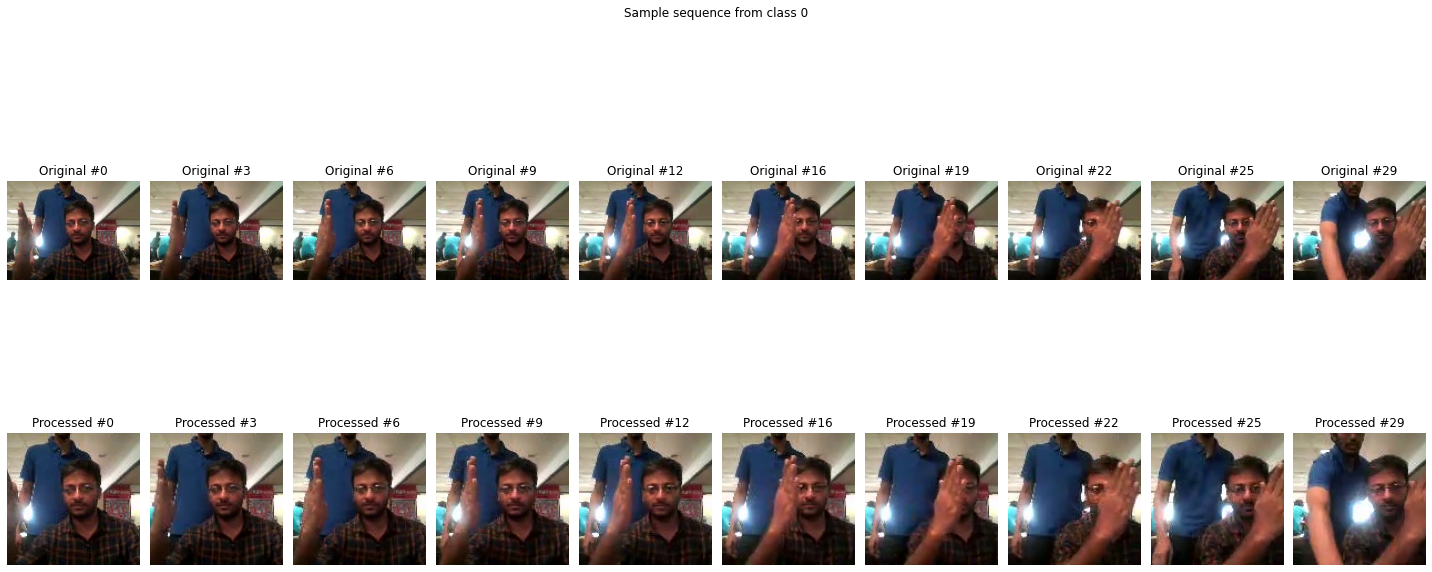

Steps per epoch: 42
Validation steps: 7
94683136/94668760 [==============================] - 6s 0us/step
Total layers in resnet: 190
Unfreezing the last 38 layers (20% of total)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 120, 120, 3)  0         
                             ]                                   
                                                                 
 time_distributed (TimeDistr  (None, 10, 2048)         23564800  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 128)          1081856   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
             

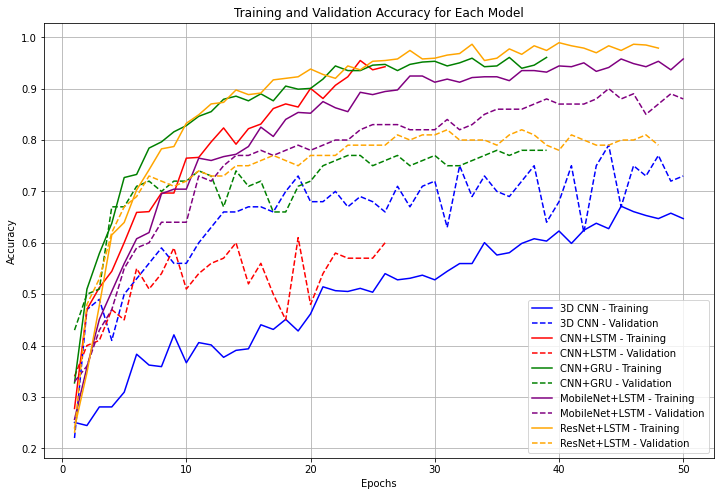

In [30]:

# MAIN EXECUTION


if __name__ == "__main__":
    # Configuration
    SEQ_LENGTH = 10          # Number of frames per sequence
    DIM_X, DIM_Y = 120, 120  # Image dimensions
    LEARNING_RATE = 0.0001   # Learning rate
    BATCH_SIZE = 32          # Batch size for standard models
    TL_BATCH_SIZE = 16       # Reduced batch size for transfer learning because of heavy memory consumption
    NUM_EPOCHS = 50          # Number of epochs
    
    print("Gesture Recognition Training")
    print(f"- Frames per sequence: {SEQ_LENGTH}")
    print(f"- Image dimensions: {DIM_X}x{DIM_Y}")
    print(f"- Learning rate: {LEARNING_RATE}")
    print(f"- Batch size (standard models): {BATCH_SIZE}")
    print(f"- Batch size (transfer learning): {TL_BATCH_SIZE}")
    print(f"- Max epochs: {NUM_EPOCHS}")
    
    # Models to train
    models = [
        {"type": "conv3d", "name": "3D CNN", "batch_size": BATCH_SIZE},
        {"type": "cnn_lstm", "name": "CNN+LSTM", "batch_size": BATCH_SIZE},
        {"type": "cnn_gru", "name": "CNN+GRU", "batch_size": BATCH_SIZE},
        {"type": "transfer", "name": "MobileNet+LSTM", "base": "mobilenet", 
         "batch_size": TL_BATCH_SIZE, "unfreeze_percent": 30},
        {"type": "transfer", "name": "ResNet+LSTM", "base": "resnet", 
         "batch_size": TL_BATCH_SIZE, "unfreeze_percent": 20}
    ]
    
    # Train each model
    results = {}
    for model_config in models:
        print(f"\n{'-'*50}")
        print(f"Training {model_config['name']} model")
        print(f"{'-'*50}")
        
        # Clear any previous model from memory
        tf.keras.backend.clear_session()
        
        # Set parameters
        params = {
            "model_type": model_config["type"],
            "batch_size": model_config["batch_size"],
            "num_epochs": NUM_EPOCHS,
            "enable_augmentation": True,
            "learning_rate": LEARNING_RATE,
            "dim_x": DIM_X,
            "dim_y": DIM_Y,
            "seq_length": SEQ_LENGTH
        }
        
        # Add transfer learning parameters if applicable
        if "base" in model_config:
            params["transfer_learning"] = True
            params["base_model"] = model_config["base"]
            
            # Add unfreeze percentage if specified
            if "unfreeze_percent" in model_config:
                params["unfreeze_percent"] = model_config["unfreeze_percent"]
        
        # Train the model
        model, history, prefix = train_gesture_model(**params)
        
        # Store results
        results[model_config["name"]] = {
            "model": model,
            "history": history,
            "best_val_acc": max(history.history['val_categorical_accuracy']),
            "best_train_acc": max(history.history['categorical_accuracy'])
        }
        
        # Clear memory
        tf.keras.backend.clear_session()
    
    # Print results
    print("\nTraining Results:")
    print(f"{'Model':<20} {'Best Validation Accuracy':<25}")
    print("-" * 45)
    for name, result in results.items():
        print(f"{name:<20} {result['best_val_acc']:.4f}")
        
    # Find the best model
    best_model_name = max(results.keys(), key=lambda k: results[k]['best_val_acc'])
    best_acc = results[best_model_name]['best_val_acc']
    
    print(f"\nBest performing model: {best_model_name} with validation accuracy of {best_acc:.4f}")
    print("All models have been saved to disk with prefix 'gesture_*_final.h5'")
    plot_training_validation_accuracy(results)
    
   